In [1]:
# 整体思路如下：
# 使用车载前置单目摄像头拍摄车辆前方的图片，从图片中识别出左右两条车道线，根据预先标定的摄像头参数（即像素数量与长度单位米的关系）
# ，计算前方左右车道线的宽度

# camera_calibration目录下是用于标定摄像头畸变尺度的图片
# test_images是用于演示计算车道线宽度的示例图片



In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


In [3]:
# 1、摄像头标定，畸变矫正

# 转换灰度图像
def grayscale(img):
    return cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)

def calibrate_camera():
    # 标定图片具有6*9个黑白棋盘交叉线顶点
    # 生成54个内交点的坐标，从(0,0,0)至(8，5，0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_calibration/calibration*.jpg')
    
    #循环标定每张照片
    for fname in images:
        img = cv2.imread(fname)
        gray = grayscale(img)

        #查找棋盘角点
        ret , corners = cv2.findChessboardCorners(gray , (9,6) , None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret , mtx , dist , rvecs , tvecs = cv2.calibrateCamera(objpoints , imgpoints , gray.shape[::-1] , None , None)
    return mtx , dist


#畸变矫正函数
def undistort(img):
    mtx , dist = calibrate_camera()
    return cv2.undistort(img , mtx , dist , None , mtx)

720 1280


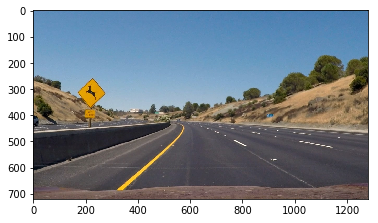

In [4]:
# 此处修改图片用于测试，共5张图片

img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

plt.imshow(img)
ysize = img.shape[0]
xsize = img.shape[1]
print(ysize,xsize)

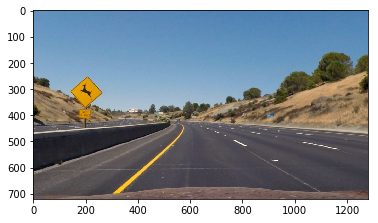

In [5]:
# 畸变矫正测试
img = undistort(img)
plt.imshow(img)

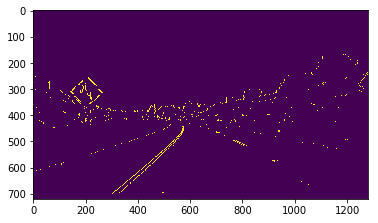

In [6]:
# 2、车道线检测

# 使用sobel算子做一维边缘检测
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = grayscale(img)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

gradx = abs_sobel_thresh(img , 'x' , 50 , 255)
plt.imshow(gradx)

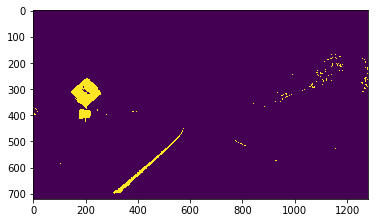

In [7]:
# hls颜色处理函数
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(img, thresh=(150, 255))
plt.imshow(hls_binary)

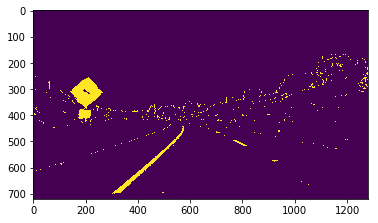

In [8]:
# 结合sobel与hls色域边缘检测得到最终的图像

final_binary = np.zeros_like(hls_binary)
final_binary[(gradx == 1) | (hls_binary == 1)] = 1
plt.imshow(final_binary)

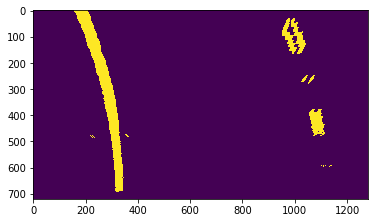

In [9]:
# 3、透视变换

# 透视转换函数
def perspective(img , src , dst):
    M = cv2.getPerspectiveTransform(src , dst)
    Minv = cv2.getPerspectiveTransform(dst , src)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped , M , Minv

# 选择矩形四个点做透视变换

src = np.float32([[244,686] , [581,459] , [704,459] , [1054,678]])
dst = np.float32([[244,686] , [244,0] , [1054,0] , [1054,678]])

#warped_img = perspective(temp_img , src , dst)
warped_img , M , Minv = perspective(final_binary , src , dst)
plt.imshow(warped_img)


In [10]:
# 4、标定像素与长度的数学关系

# 假设test5.jpg的图片作为标定图片,测量图片中左右车道线像素中点的距离大约是800个像素
# ，然后测量实际道路的宽度，假设为3.7米，则每个像素代表的距离长度为3.7/800米，前提是透视变换模型不可以再变更


meter_per_pix = 3.7 / 800

In [11]:
# 5、确认左右两条车道线像素的准确位置

# 画出基于x轴的像素直方图，决定车道线跟踪的起始位置
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# 确认最终车道线的像素点，主要运用滑动窗口的方法进行跟踪
def find_lane_pixels(binary_warped):
    histogram = hist(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # 计算车辆的中心位置
    center_position = (rightx_base - leftx_base) / 2 + leftx_base
    
    # 滑动窗口参数
    nwindows = 9
    margin = 80
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # 标记window位置
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)    

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))        

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
            
    return leftx, lefty, rightx, righty, out_img , center_position

# 计算多项式拟合参数
def fit_polynomial(leftx , lefty , rightx , righty , out_img):
    
    # 用二次多项式拟合左右两条车道线
    left_fit = np.polyfit(lefty , leftx , 2)
    right_fit = np.polyfit(righty , rightx , 2)

    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )

        
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print(left_fit[2])
    print(right_fit[2])
        
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='blue')
    plt.plot(right_fitx, ploty, color='blue')

    return out_img , left_fit , right_fit , ploty , left_fitx , right_fitx



181.95640839993825
963.6280980044768


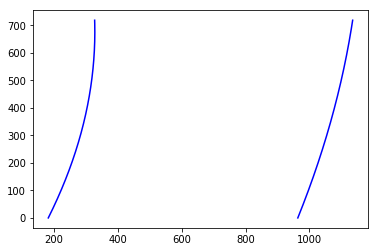

In [12]:
leftx , lefty , rightx , righty , out_img , center_position = find_lane_pixels(warped_img)
out_img , left_fit , right_fit , ploty , left_fitx , right_fitx = fit_polynomial(leftx , lefty , rightx , righty , out_img)

In [13]:
# 6、计算车道线宽度

y_zero = 0  # 计算y坐标为0时的左右两侧车道线的距离
left_fit_zero = left_fit[0] * y_zero ** 2 + left_fit[1] * y_zero + left_fit[2]
right_fit_zero = right_fit[0]* y_zero ** 2 + right_fit[1] * y_zero + right_fit[2]

width = (right_fit_zero - left_fit_zero) * meter_per_pix
print("车道线宽度为 %.2f 米" %width)



车道线宽度为 3.62 米
